<a href="https://colab.research.google.com/github/lstarke/reinforcement_learning_practice_1/blob/main/Trabalho_Pratico_I_Problema_de_Transporte_de_Objeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [20]:
class Mundo():

  PAREDE = -1
  BASE   = 1
  OBJETO = 2
  AGENTE = 3

  def __init__(self):  

    # definindo tamanho do mundo
    self.num_linhas = 6
    self.num_colunas = 7
    # matriz com valor -1 em cada célula, este é o valor da recompensa 
    # que o agente recebe ao caminhar pelo mundo.
    self.matriz = np.zeros((6, 7)) -1

    # definido posições iniciais do agente, base, objeto e paredes
    self.pos_agente = (5, 0)
    self.pos_base = [(0, 2), (0, 3), (0, 4)]
    self.pos_objeto = (2, 3)
    self.pos_paredes = [(4, 0), (4, 1), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6), (1, 3)] # estados não válidos
    
    # definindo as recompensas
    # quando consegue chegar a uma célula base recebe 5 de recompensa
    # celulas ao lado do objeto receberam 1 de recompensa
    # 
    # em testes realizados usando pontuação igual tando para células de base
    # como em células que estão do lado do objeto o agente ficava encalhado
    # sendo assim, deixei uma recompensa menor para o objeto e maior para a base
    #
    self.matriz[self.pos_base[0][0], self.pos_base[0][1]] = 5
    self.matriz[self.pos_base[1][0], self.pos_base[1][1]] = 5
    self.matriz[self.pos_base[2][0], self.pos_base[2][1]] = 5
    self.matriz[2, 2] = 1 # recompensa maior para as celulas ao lado do objeto
    self.matriz[2, 4] = 1 # recompensa maior para as celulas ao lado do objeto

    # definindo as ações do agente que o agente pode executar
    self.acoes = ['SUBIR', 'DESCER', 'DIREITA', 'ESQUERDA']

  def executa_passo(self, acao):

    ultima_pos_agente = self.pos_agente
    
    # executa a movimentação
    # caso o agente está nas extremidades ou encontra uma parede ele 
    # permanece no mesmo lugar.  
    if acao == 'SUBIR':
      if ultima_pos_agente[0] == 0 or self.is_parede((ultima_pos_agente[0]-1, ultima_pos_agente[1])):
        recompensa = self.busca_recompensa(ultima_pos_agente)
      else:
        self.pos_agente = (self.pos_agente[0]-1, self.pos_agente[1])
        recompensa = self.busca_recompensa(self.pos_agente)
    elif acao == 'DESCER':
      if ultima_pos_agente[0] == self.num_linhas-1 or self.is_parede((ultima_pos_agente[0]+1, ultima_pos_agente[1])):
        recompensa = self.busca_recompensa(ultima_pos_agente)
      else:
        self.pos_agente = (self.pos_agente[0]+1, self.pos_agente[1])
        recompensa = self.busca_recompensa(self.pos_agente)
    elif acao == 'DIREITA':
      if ultima_pos_agente[1] == self.num_colunas-1 or self.is_parede((ultima_pos_agente[0], ultima_pos_agente[1]+1)):
        recompensa = self.busca_recompensa(ultima_pos_agente)
      else:
        self.pos_agente = (self.pos_agente[0], self.pos_agente[1]+1)
        recompensa = self.busca_recompensa(self.pos_agente)
    elif acao == 'ESQUERDA':
      if ultima_pos_agente[1] == 0 or self.is_parede((ultima_pos_agente[0], ultima_pos_agente[1]-1)):
        recompensa = self.busca_recompensa(ultima_pos_agente)
      else:
        self.pos_agente = (self.pos_agente[0], self.pos_agente[1]-1)
        recompensa = self.busca_recompensa(self.pos_agente)

    return recompensa

  def busca_recompensa(self, posicao):
    return self.matriz[posicao[0], posicao[1]]

  def is_estado_terminal(self):
    if self.pos_agente in self.pos_base:
      return True
    return False

  def is_parede(self, posicao):
    if posicao in self.pos_paredes:
      return True
    return False      

  def imprime_mundo(self):
    mundo = self.matriz = np.zeros((6, 7))
    mundo[self.pos_agente[0], self.pos_agente[1]] = self.AGENTE
    mundo[self.pos_base[0], self.pos_base[1]] = self.BASE
    mundo[self.pos_objeto[0], self.pos_objeto[1]] = self.OBJETO
    for pos_parede in self.pos_paredes:
      mundo[pos_parede[0], pos_parede[1]] = self.PAREDE
    print(self.matriz)

In [21]:
class Agente():

  def __init__(self, mundo, epsilon=0.1, alpha=0.1, gamma=0.9):
    self.mundo = mundo
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.pegou_objeto = False
    self.q_valores = dict() 
    # montagem de um dicionário com os q valores calculádos.     
    for linha in range(mundo.num_linhas):
      for coluna in range(mundo.num_colunas):
        self.q_valores[(linha, coluna)] = {'SUBIR':0, 'DESCER':0, 'DIREITA':0, 'ESQUERDA':0}

  # função que define a ação que o agente irá executar,
  # fazendo um balanceamento entre exploração e aproveitamento.
  def escolhe_acao(self, acoes):    
    if np.random.uniform(low=0, high=1) < self.epsilon:
      acao = acoes[np.random.randint(0, len(acoes))]
    else:
      q_valores_estado = self.q_valores[self.mundo.pos_agente]
      #print(f'q valores: {q_valores_estado}')
      maior_valor = max(q_valores_estado.values())
      acao = np.random.choice([k for k, v in q_valores_estado.items() if v == maior_valor])
    return acao

  # o objeto só pode ser agarrado pela sua direta ou esquerda
  def agarrar_objeto(self):
    if not self.pegou_objeto:
      if self.mundo.pos_agente[0] == self.mundo.pos_objeto[0] and self.mundo.pos_agente[1]+1 == self.mundo.pos_objeto[1] or \
         self.mundo.pos_agente[0] == self.mundo.pos_objeto[0] and self.mundo.pos_agente[1]-1 == self.mundo.pos_objeto[1]: 
         self.pegou_objeto = True
         #print('### Pegou o objeto ###')

  # atualizando valores da taxa de aprendizagem
  # conforme agente interage com o ambiente
  def atualiza_q_valores(self, estado_anterior, recompensa, estado_novo, acao):
    q_valores_estado = self.q_valores[estado_novo]
    maior_q_valor_estado_novo = max(q_valores_estado.values())
    q_valor_atual = self.q_valores[estado_anterior][acao]
    self.q_valores[estado_anterior][acao] = (1 - self.alpha) * q_valor_atual + self.alpha * (recompensa + self.gamma * maior_q_valor_estado_novo)
    #print(f'q valores atualizados: {self.q_valores[estado_anterior]}')

###Implementação Q-learning

![](https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png)

In [24]:
def play(mundo, agente, num_tentativas=100, num_passos_por_episodio=500, verbose=False):

  recompensa_por_episodio = []
  
  for tentativa in range(num_tentativas):

    recompensa_acumulada = 0
    passo = 0
    fim_de_jogo = False

    tempo_inicio = time.time()      
    while passo < num_passos_por_episodio and fim_de_jogo != True:      

      estado_atual = mundo.pos_agente      
      acao = agente.escolhe_acao(mundo.acoes)     
      recompensa = mundo.executa_passo(acao)      
      estado_novo = mundo.pos_agente  
      agente.agarrar_objeto()  
      agente.atualiza_q_valores(estado_atual, recompensa, estado_novo, acao)
      recompensa_acumulada += recompensa
      passo += 1

      if verbose:
        print(f'Saiu de {estado_atual} andou para {acao} e está em {estado_novo}. Recompensa: {recompensa}')
        print('#'*100)

      if mundo.is_estado_terminal() and agente.pegou_objeto == True:
        mundo.__init__()
        fim_de_jogo = True
        print(f'Fim. Chegou na Base com o objeto.\tTentativa: {tentativa},\tQtde passos: {passo}. \tTempo de execução: {(time.time() - tempo_inicio)} segundos')

    if verbose:
      if not fim_de_jogo:
        print('#'*50)
        print('Fim. Alcançou o número de episódios.')
        print('#'*50)

    recompensa_por_episodio.append(recompensa_acumulada)

  return recompensa_por_episodio

### Execução

Fim. Chegou na Base com o objeto.	Tentativa: 0,	Qtde passos: 60. 	Tempo de execução: 0.004899501800537109 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 1,	Qtde passos: 54. 	Tempo de execução: 0.002370595932006836 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 2,	Qtde passos: 66. 	Tempo de execução: 0.0038013458251953125 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 3,	Qtde passos: 32. 	Tempo de execução: 0.00072479248046875 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 4,	Qtde passos: 31. 	Tempo de execução: 0.0006868839263916016 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 5,	Qtde passos: 21. 	Tempo de execução: 0.0004968643188476562 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 6,	Qtde passos: 29. 	Tempo de execução: 0.0007424354553222656 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 7,	Qtde passos: 36. 	Tempo de execução: 0.0011169910430908203 segundos
Fim. Chegou na Base com o objeto.	Tentativa: 8,	Qtde passos: 27. 	Tempo de e

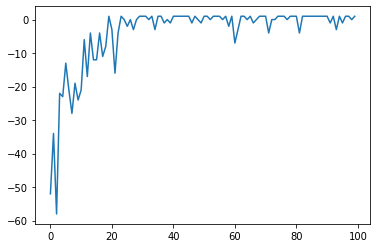

In [25]:
mundo = Mundo()
agente = Agente(mundo)
recompensa_por_episodio = play(mundo, agente, verbose=False)
plt.plot(recompensa_por_episodio)

### Política

In [26]:
import pprint
pprint.pprint(agente.q_valores)

{(0, 0): {'DESCER': -0.1, 'DIREITA': -0.1, 'ESQUERDA': 0, 'SUBIR': 0},
 (0, 1): {'DESCER': -0.10900000000000001,
          'DIREITA': 0,
          'ESQUERDA': -0.1,
          'SUBIR': -0.1},
 (0, 2): {'DESCER': 0, 'DIREITA': 0, 'ESQUERDA': 0, 'SUBIR': 0},
 (0, 3): {'DESCER': 0, 'DIREITA': 0, 'ESQUERDA': 0, 'SUBIR': 0},
 (0, 4): {'DESCER': 0, 'DIREITA': 0, 'ESQUERDA': 0, 'SUBIR': 0},
 (0, 5): {'DESCER': 0, 'DIREITA': -0.1, 'ESQUERDA': 0.5, 'SUBIR': -0.1},
 (0, 6): {'DESCER': -0.1, 'DIREITA': 0, 'ESQUERDA': -0.1, 'SUBIR': -0.1},
 (1, 0): {'DESCER': -0.1, 'DIREITA': -0.1, 'ESQUERDA': -0.1, 'SUBIR': -0.1},
 (1, 1): {'DESCER': 0.22515883142319934,
          'DIREITA': -0.1,
          'ESQUERDA': -0.1,
          'SUBIR': -0.1},
 (1, 2): {'DESCER': 0.24343301484950503,
          'DIREITA': 0.259101494850043,
          'ESQUERDA': -0.4062748642945606,
          'SUBIR': 4.999852436672848},
 (1, 3): {'DESCER': 0, 'DIREITA': 0, 'ESQUERDA': 0, 'SUBIR': 0},
 (1, 4): {'DESCER': 0, 'DIREITA': 0, 'ES

###Referências

[Gridworld-with-Q-Learning-Reinforcement-Learning](https://github.com/michaeltinsley/Gridworld-with-Q-Learning-Reinforcement-Learning-)